In [15]:
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from lifelines import KaplanMeierFitter

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_dictionary = pd.read_csv('data_dictionary.csv')


In [4]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [3]:
data_dictionary

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


In [22]:
## encode variables as labels

train['efs_time'][train['efs_time'] > 25]

0         42.356
3        102.349
6         46.464
12        91.999
15       125.465
          ...   
28779     56.493
28781     40.059
28785     39.609
28798     52.351
28799     25.158
Name: efs_time, Length: 10111, dtype: float64

In [11]:
train['efs']  # 

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
28795    0.0
28796    1.0
28797    0.0
28798    0.0
28799    0.0
Name: efs, Length: 28800, dtype: float64

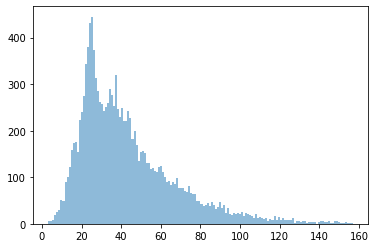

In [16]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    df_ = df.loc[(df[time_col] < 24) | (df[event_col] == 0)]
    kmf.fit(df_[time_col], df_[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    plt.hist(df.efs_time[df[event_col] == 0], bins=150, alpha=0.5, label="Event")
    plt.show()
    #y = y / (y.max() - y.min())
    # y = np.log(1 + np.log(y / (1 - y)))
    return y

y = transform_survival_probability(train, time_col='efs_time', event_col='efs')


In [32]:
"hla_low_res_6" in train.columns


True